<a href="https://colab.research.google.com/github/sebastianfernandezgarcia/DetectorBasuraMarinaYoloV7/blob/main/Trabajo_Final_VC_Jiten_Sebasti%C3%A1n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

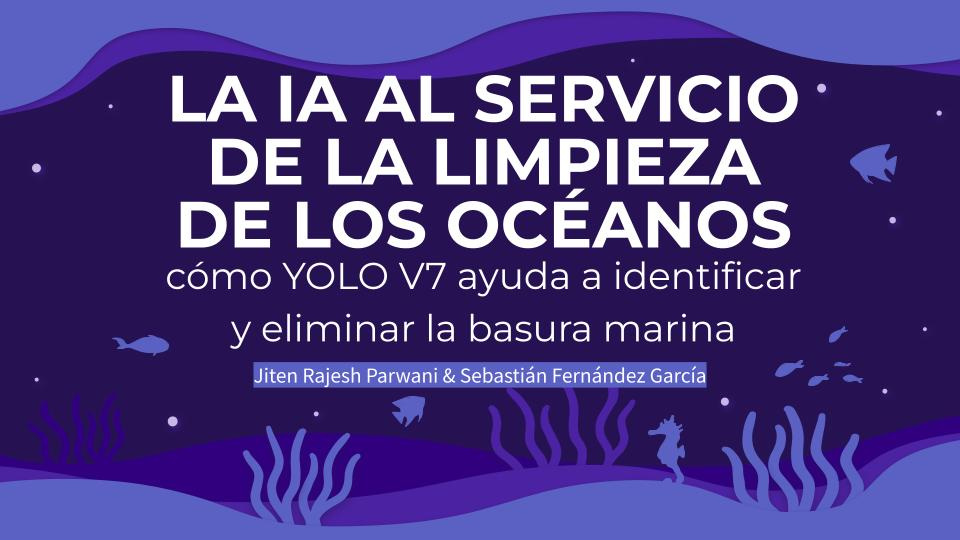



# Importación de Yolo V7

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

# Descargamos Repositorio de YoloV7 e instalamos los requerimientos
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt

# Preparación de los datos.

Este es un dataset específico que hemos diseñado en concreto para este trabajo. Combinando otros varios datasets disponibles, de peces, elementos marinos, basura... Varios han sido combinados y limpiados a mano, empaquetándolos en un único proyecto de roboflow para facilitar la etiquetación de los datos y su almacenamiento.

La siguiente celda, descarga, descomprime y guarda todo apropiadamente para continuar con una fluida ejecución en un cuardeno de Google Colab. En caso de estar en local, es posible que se deban cambiar las rutas a las personalizadas en su propio equipo.

# Estructura 
Los datos se encuentran estructurados de la siguiente manera:
- test
  - images
  - labels
-train
  - images
  - labels
-valid
  - images
  - labels
-data.yaml


En el data.yalm definimos las dos clases que clasificaremos. Peces y basura.

In [ ]:
# Descargamos el dataset etiquetado para yoloV7, en este caso son 
# imágenes de animales marinos y basura, bajo el mar
%cd /content
%mkdir dataset
%cd /content/dataset
!curl -L "https://app.roboflow.com/ds/atC6iAeKxO?key=68fbCtvXvO" > dataset.zip
!unzip dataset.zip
!rm dataset.zip
%cd /content

In [ ]:
# Creamos un fichero yaml modificado para que pueda funcionar en Google Colab 
# (se modifica el directorio a donde se acceden los conjuntos de train, test y val)
!echo "train: ../dataset/train" > data_sea_trash.yaml
!echo "test: ../dataset/test" >> data_sea_trash.yaml
!echo "val: ../dataset/valid" >> data_sea_trash.yaml
!echo "nc: 2" >> data_sea_trash.yaml
!echo "names: ['fish', 'trash']" >> data_sea_trash.yaml

# Descarga de pesos iniciales para YoloV7
A partir de estos pesos, haremos transfer learning para aprender a detectar los residuos marinos.

In [ ]:
# Nos descargamos unos pesos iniciales de YoloV7 para proceder a hacer transfer learning posteriormente
%cd /content/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

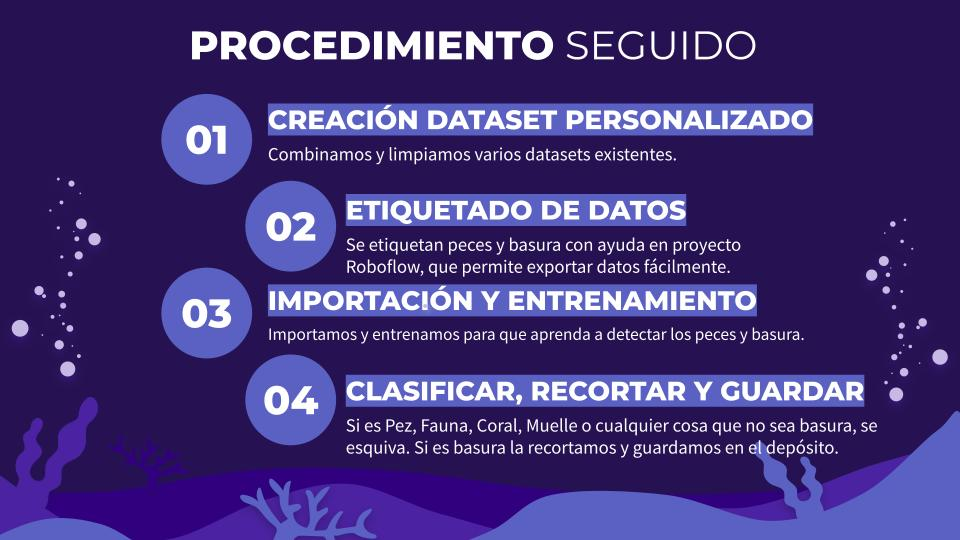

# Iniciamos el entrenamiento

## Si hay error en loss.py... (se encuentra en la carperta utils)
Tras unas cuantas horas viendo que hacer, ocurría un error en el loss.py, parece ser que es un bug en la implementación o que simplemente, por naturaleza con pytorch, los datos tienen que moverse a la GPU para ser usados y tiene que estar todo en GPU o habrá problemas. Esto se soluciona añadiendo 2 simples líneas el ficheros de loss.py

## Qué hacer si falla
Tras la línea 685 de loss.py añadir:
# 
from_which_layer.append((torch.ones(size=(len(b),)) * i).to('cuda'))

Tras la línea 756 de loss.py añadir:
# 
fg_mask_inboxes = fg_mask_inboxes.to(torch.device('cuda'))

# No obstante, en la siguiente celda se importa el fichero con las dos líneas mencionadas cambiadas.
Si no desea cambiar esto a mano, ponemos esta celda que es un script para borrar el actual loss.py y traer uno ya corregido.


In [ ]:
%cd /content/yolov7/utils
!rm loss.py
!wget https://raw.githubusercontent.com/sebastianfernandezgarcia/otsedom.github.io/main/VC/P7/loss.py

# Con esto comenzamos el entrenamiento. 

- Si no desea esperar a que se complete, puede bajar el número de epochs o...
  - Hemos facilitado unos pesos ya entrenados más adelante con el mejor resultado de este entrenamiento que tomó un par de horas.

- Si desea ir a ver directamente los resultados, puedes ahorrarte la ejecución de la siguiente celda.

In [ ]:
%cd /content/yolov7
!python train.py --batch 15 --epochs 100 --data /content/data_sea_trash.yaml --weights 'yolov7_training.pt' --device 0 


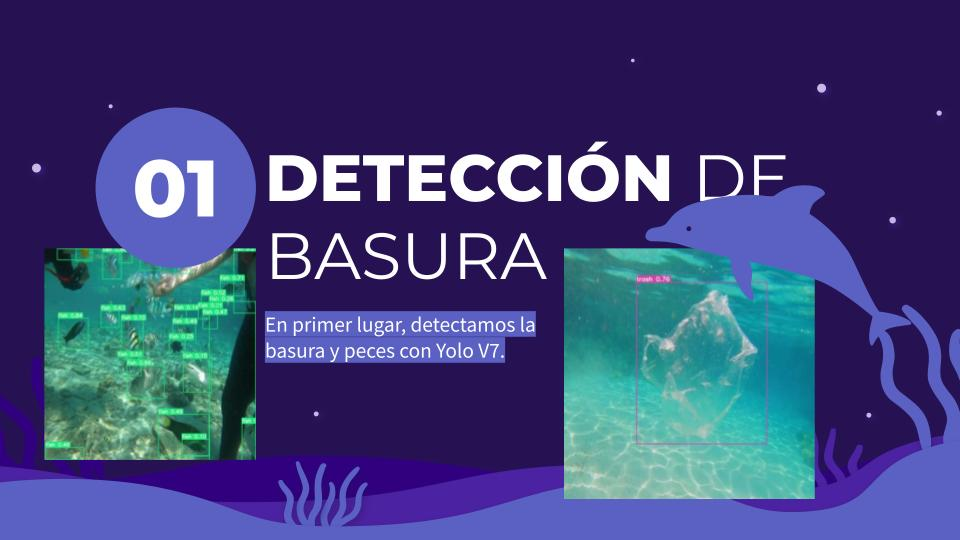

# Evaluación

Aquí tenemos dos caminos.


1.   Si ha ejecutado el entrenamiento ahora mismo en su google Colab.
2.   Si quiere cargar los pesos que ya entrenamos nosotros por usted.

# 1) Acabo de terminar de entrenar ahora mismo en mi collab
Genial, dejamos la siguiente celda que cogerá los pesos locales de su propio entorno de ejecución.

NOTAS: Si has hecho más de 1 ejecución es posible que tengas que cambiar donde pone exp por exp2...exp5... la más reciente que tengas.

In [ ]:
# Run evaluation
%cd /content/yolov7
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.1 --source /content/dataset/test/images  --img-size 416 --name /content/myResults --save-txt #Cambiar la carpeta exp si hay alguna posterior


# 2) Quiero descargar los pesos que ya han sido entrenado con bastente tiempo y probar resultados
De acuerdo, primero, descargamos los pesos que han sido entrenados y los pondremos en una carpeta para tenerlos localizados. Posteriormente ejecutamos el detector pero con los pesos descargados

In [ ]:
#Vamos a guardar los pesos en la carpeta general para tenerlos a mano 
%cd /content/yolov7
!wget https://github.com/sebastianfernandezgarcia/DetectorBasuraMarinaYoloV7/raw/main/best_sea_trash.pt

# #Una vez bajados, podemos iniciar la deteccion con estos pesos que ya hemos entrenado con bastante tiempo
!python detect.py --weights /content/yolov7/best_sea_trash.pt --conf 0.1 --source /content/dataset/test/images  --img-size 416 --name /content/myResults --save-txt

# Elección de BASURA o PEZ

La siguiente celda es una función que describe la decisión que el dron submarino debe tomar. En este caso, esquivar si es un animal marino, y recoger si es basura.

Cargaremos los datos tras la detección de YoloV7. Con esto sabremos si tenemos delante un pez o basura. En el caso de ser basura, la deberemos recoger y guardar en el contedor del robot. (Recortamos la imagen simulando que cogemos en ese espacio el objeto y la guardamos en carpetas específicas, simulando guardarlo en el contendor del robot)

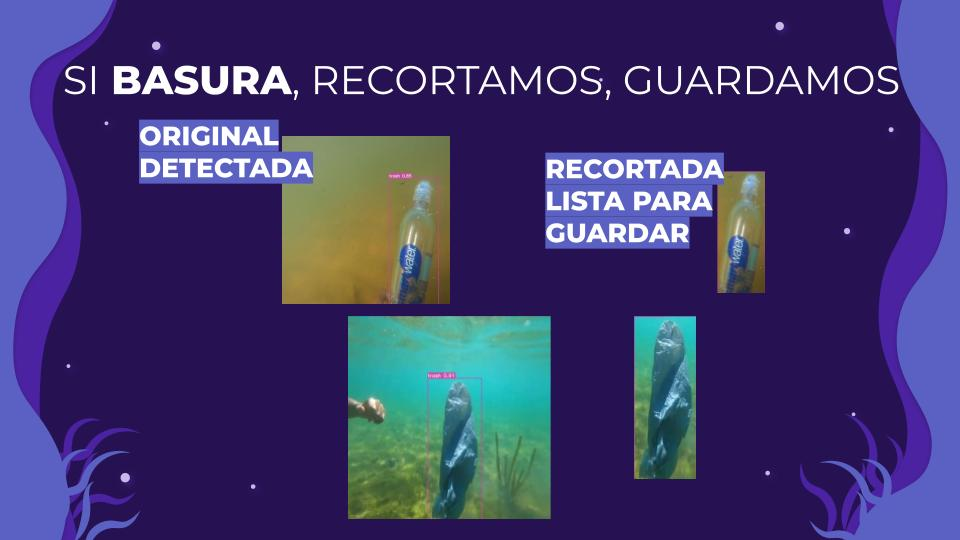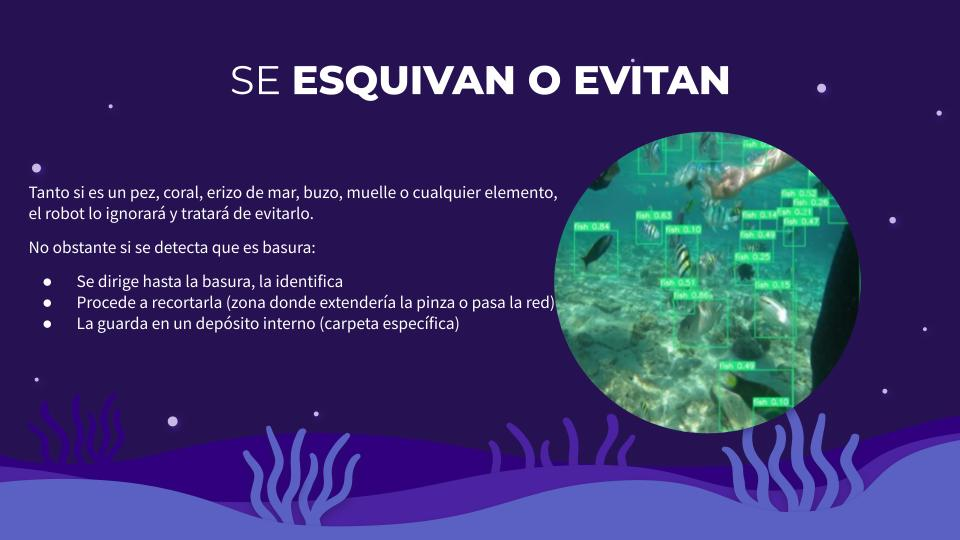



In [ ]:
def take_decision(img_source_path, txt_result_path):

    # Carga de imagen a procesar
    img = cv2.imread(img_source_path)

    # LECTURA DE COORDENADAS DE LA DETECCIÓN
    detections = []

    try:
        with open(txt_result_path) as f:

            # Cada línea es una detección en la misma imagen
            for line in f:
                
                detection_info = (line.strip())
                detection_info = detection_info.split()            
                detections.append(detection_info)


            # RECORTE Y FOCALIZACIÓN DE LA DETECCIÓN
            all_xywhc = []

            for detection in detections:
                
                # Coordenadas del centro del box y dimensiones
                cls = int(detection[0])
                x = round(float(detection[1]) * img.shape[0])
                y = round(float(detection[2]) * img.shape[1])
                w = round(float(detection[3]) * img.shape[0])
                h = round(float(detection[4]) * img.shape[1])

                # Coordenadas de esquina del bounding box
                x = x - (w >> 1)
                y = y - (h >> 1)
                
                # Guarda coordenadas y dimensiones
                xywhc = [x, y, w, h, cls]
                all_xywhc.append(xywhc)

            # Número de la instancia en una misma imagen
            n_inst = 0

            for x, y, w, h, c in all_xywhc:

                # Recorte de imagen
                img_crop = img[y : y + h, x: x + w] #Se recorta la imagen con la forma que da Yolo del bounding box
                
                # Si es basura, se "recoge", sino, es un animal marino y se esquiva
                filepath_img_crop = "/content/Catch/"
                if c == 0:
                  filepath_img_crop = "/content/Dodge/"
                  
                # Para cada instancia en una imagen, se guarda con un atributo numérico distinto
                name = os.path.splitext(os.path.basename(img_source_path))[0] + "_inst_" + str(n_inst) + ".jpg"
                name = os.path.basename(name)
                cv2.imwrite(filepath_img_crop + name, img_crop)

                n_inst += 1
    except:
      pass

La siguiente celda llama a la función anterior para tomar la decisión.

In [ ]:
# INICIO DEL SCRIPT - RECORRIDO Y PROCESAMIENTO DE CADA IMAGEN

# Ruta de imágenes
imgs_source_path = "/content/myResults" + "/*.jpg"
resultado_txt = {}

# Rutas donde se guardarán los recortes de las detecciones.
# En Dodge se guardan los animales marinos a esquivar.
# En Catch se guardan la basura a recoger.
!rm -rf /content/Dodge
!rm -rf /content/Catch
!mkdir /content/Dodge
!mkdir /content/Catch

for imageName in glob.glob(imgs_source_path):

    # Ruta con los txt generados tras la inferencia
    txt_result_path = '/content/myResults/labels/' + os.path.basename(imageName)

    txt_result_path = os.path.splitext(txt_result_path)[0] + ".txt"

    take_decision(imageName, txt_result_path)

# Resultados RAW
Anteriormente acabamos de mostrar una vista sintetizada de los resultados obtenidos, ahora, para demostrar o si hubiese necesidad, se muestran los datos en crudo directamente con los resultados puros.

En esta celda se muestran las imágenes y sus subimágenes capturadas.

Nombre del siguiente archivo: /content/myResults/frame_00250_png_jpg.rf.fe98023f94554e42a6c7ebf7eeaaa71b.jpg



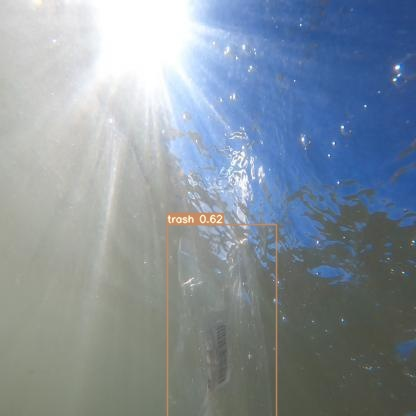


Instancia de basura a capturar número 1



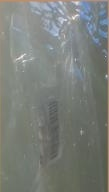



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.7896a6ddb02d46c448f897fc9cba317b.jpg



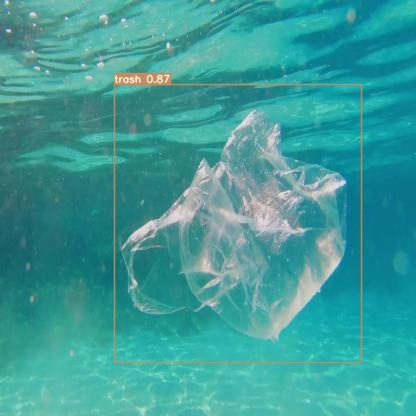


Instancia de basura a capturar número 1



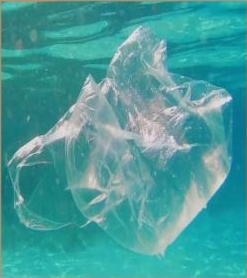



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00250_png_jpg.rf.4a3abd9a371b878eaee5460ff3821ea9.jpg



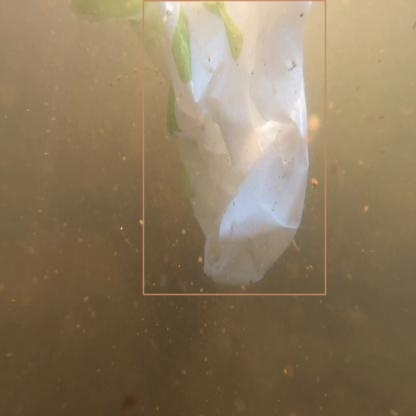


Instancia de basura a capturar número 1



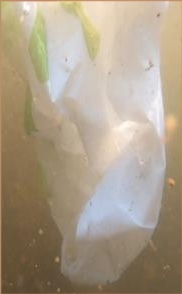



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00250_png_jpg.rf.cfdcccdb2c8c22142ca840aefca22b41.jpg



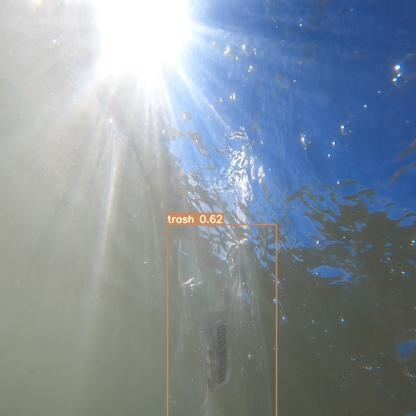


Instancia de basura a capturar número 1



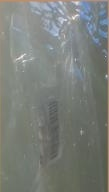



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00300_png_jpg.rf.4af6a4357938e460fea397c4393c8edd.jpg



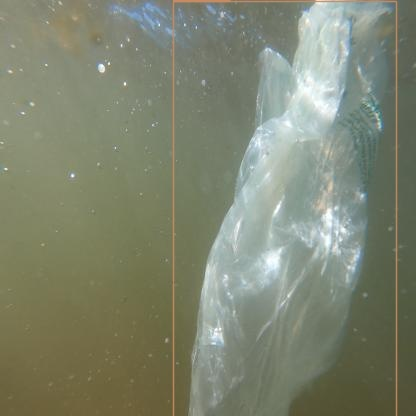


Instancia de basura a capturar número 1



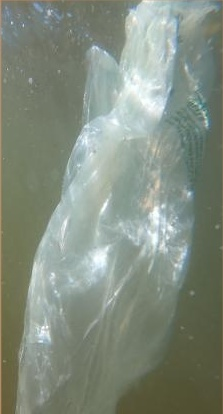



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.8967b203204855bf4dc155fae326039e.jpg



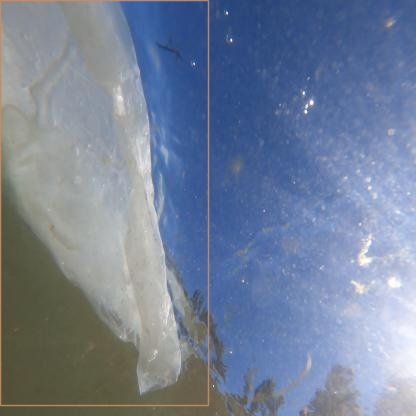


Instancia de basura a capturar número 1



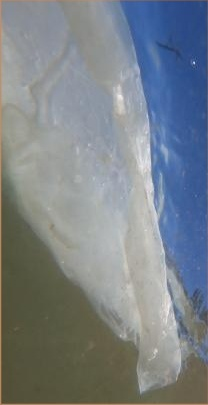



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.b6b5ca7a9ba5fcf777519bcb1f96752a.jpg



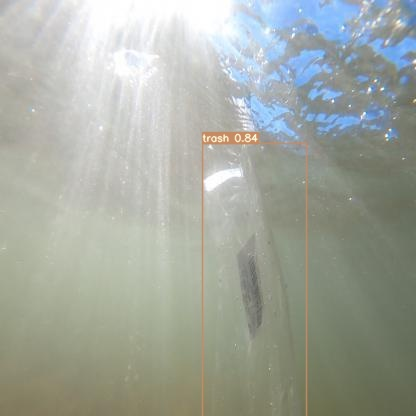


Instancia de basura a capturar número 1



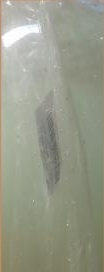



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/29_img__png_jpg.rf.5534f241627b184d04a2421fbd6ef019.jpg



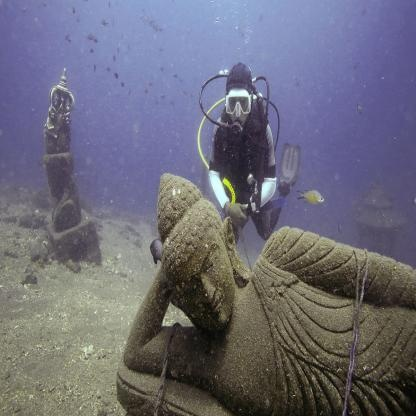



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/12348_png_jpg.rf.7d6c4e3446a7489c084358c30c9a5f3e.jpg



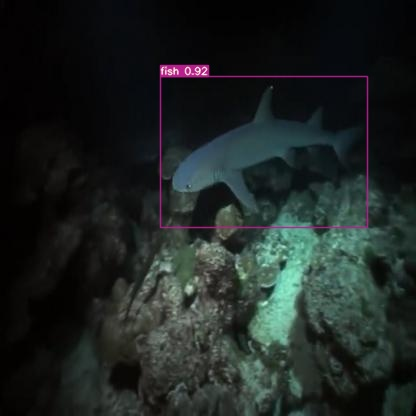


Instancia de animal marino a esquivar número 1



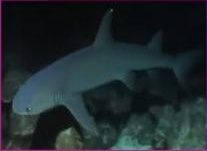



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/2787_png_jpg.rf.f815e463c8d990397271ade20d253b96.jpg



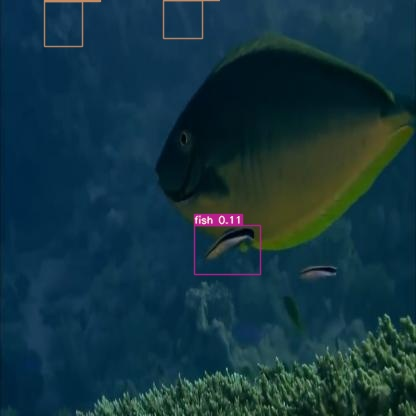


Instancia de basura a capturar número 1



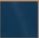


Instancia de basura a capturar número 2



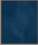


Instancia de animal marino a esquivar número 1



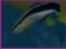



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00200_png_jpg.rf.65db72f2ef2451e117bc8fb7e2c347f7.jpg



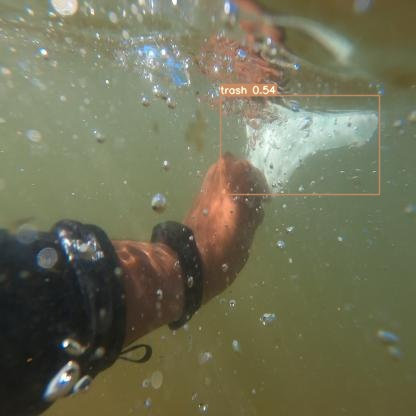


Instancia de basura a capturar número 1



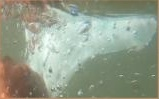



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.0c10222dcd6a4a3de3389654b5083dbc.jpg



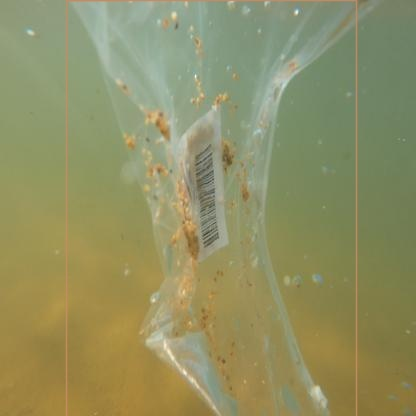


Instancia de basura a capturar número 1



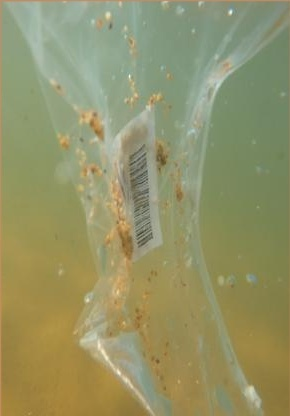



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/3925_png_jpg.rf.b95e706ea447340fd24a5ebe030ba38b.jpg



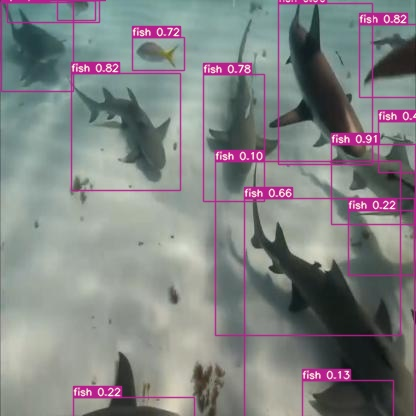


Instancia de animal marino a esquivar número 1




Instancia de animal marino a esquivar número 2



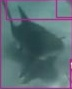


Instancia de animal marino a esquivar número 3



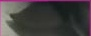


Instancia de animal marino a esquivar número 4



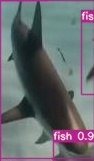


Instancia de animal marino a esquivar número 5



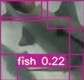


Instancia de animal marino a esquivar número 6



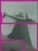


Instancia de animal marino a esquivar número 7



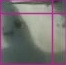


Instancia de animal marino a esquivar número 8



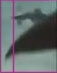


Instancia de animal marino a esquivar número 9



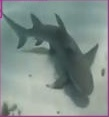


Instancia de animal marino a esquivar número 10




Instancia de animal marino a esquivar número 11




Instancia de animal marino a esquivar número 12



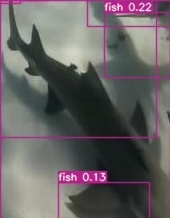


Instancia de animal marino a esquivar número 13



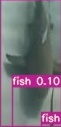


Instancia de animal marino a esquivar número 14



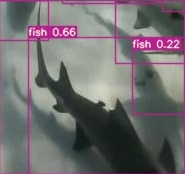


Instancia de animal marino a esquivar número 15



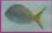



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00270_png_jpg.rf.59ca67e8909d300dee737252fe7295f7.jpg



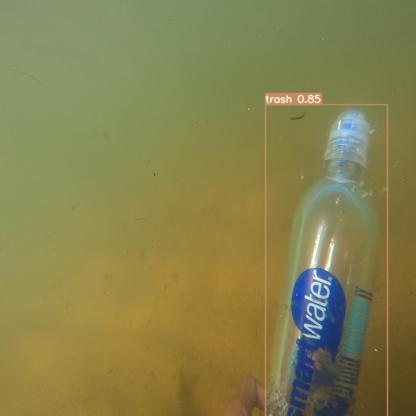


Instancia de basura a capturar número 1



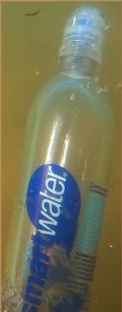



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00350_png_jpg.rf.3dc07fdc7f9869d2f3231b7dd175b507.jpg



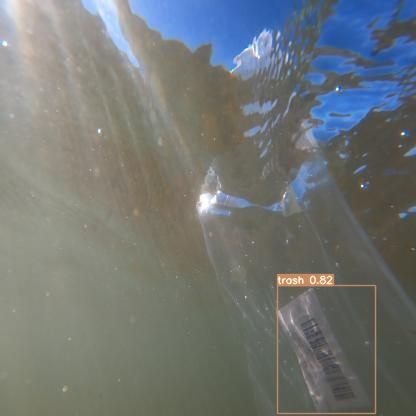


Instancia de basura a capturar número 1



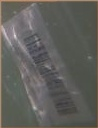



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.65f34c33744320cba25f0ab0796e4fec.jpg



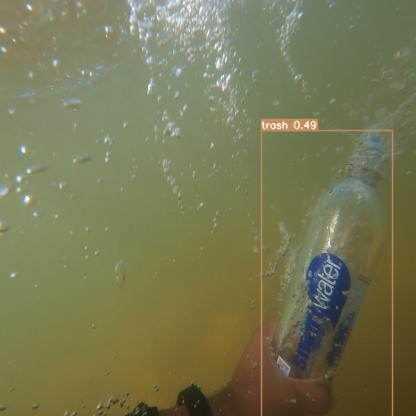


Instancia de basura a capturar número 1



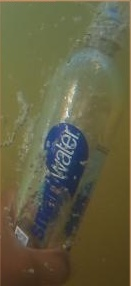



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/311_img__png_jpg.rf.81f13d749dcee92d1213a3cf2139d33e.jpg



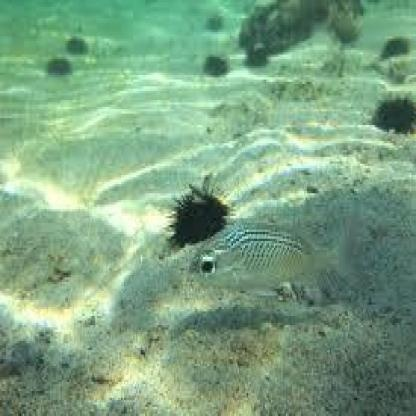



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/2701_png_jpg.rf.034a47c555ee5d682279a8d85cd980b6.jpg



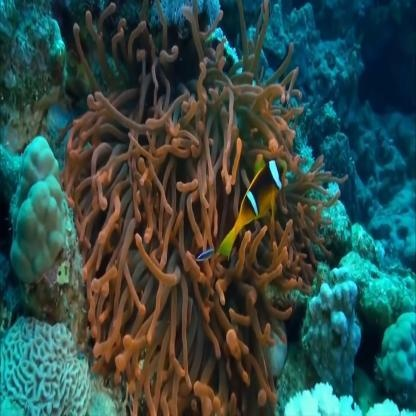



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00250_png_jpg.rf.3ca6ed764f2161d66659963fb277129f.jpg



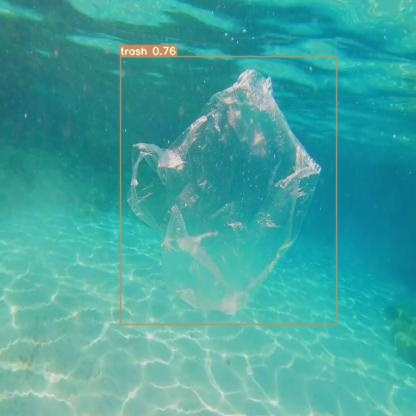


Instancia de basura a capturar número 1



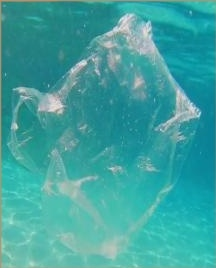



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.2231244b2da75ac24ae9f43c5bdc9395.jpg



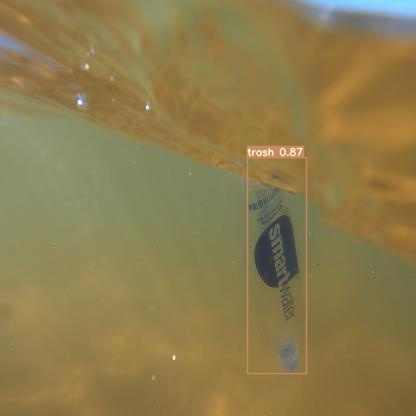


Instancia de basura a capturar número 1



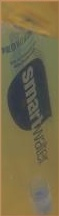



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00200_png_jpg.rf.8b2be555e5b7abf4075b4c8a529dc280.jpg



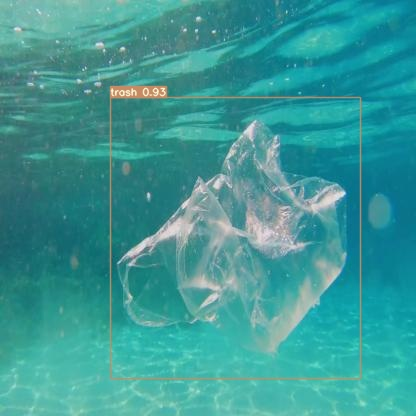


Instancia de basura a capturar número 1



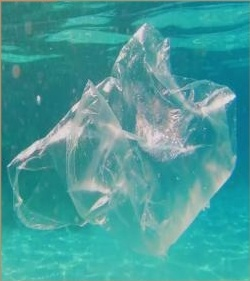



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/180_img__png_jpg.rf.10cb2715d33155b4c0721e9faf743a9e.jpg



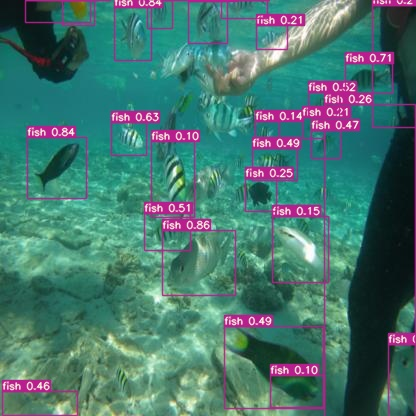


Instancia de animal marino a esquivar número 1




Instancia de animal marino a esquivar número 2




Instancia de animal marino a esquivar número 3




Instancia de animal marino a esquivar número 4



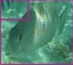


Instancia de animal marino a esquivar número 5



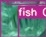


Instancia de animal marino a esquivar número 6



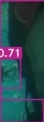


Instancia de animal marino a esquivar número 7



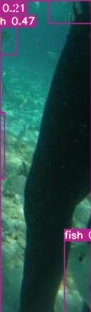


Instancia de animal marino a esquivar número 8




Instancia de animal marino a esquivar número 9




Instancia de animal marino a esquivar número 10




Instancia de animal marino a esquivar número 11



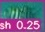


Instancia de animal marino a esquivar número 12




Instancia de animal marino a esquivar número 13




Instancia de animal marino a esquivar número 14



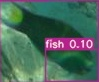


Instancia de animal marino a esquivar número 15



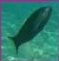


Instancia de animal marino a esquivar número 16




Instancia de animal marino a esquivar número 17



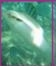


Instancia de animal marino a esquivar número 18




Instancia de animal marino a esquivar número 19




Instancia de animal marino a esquivar número 20



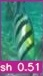


Instancia de animal marino a esquivar número 21



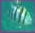


Instancia de animal marino a esquivar número 22




Instancia de animal marino a esquivar número 23



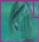


Instancia de animal marino a esquivar número 24




Instancia de animal marino a esquivar número 25



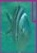


Instancia de animal marino a esquivar número 26



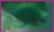



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00375_png_jpg.rf.adea1548c33b00012880a525344e1e19.jpg



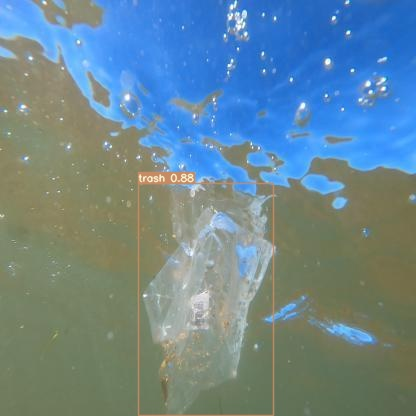


Instancia de basura a capturar número 1



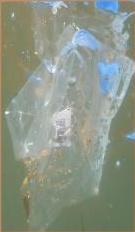



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/296_img__png_jpg.rf.0b1783e51f01729dcba12fcc5d9fd524.jpg



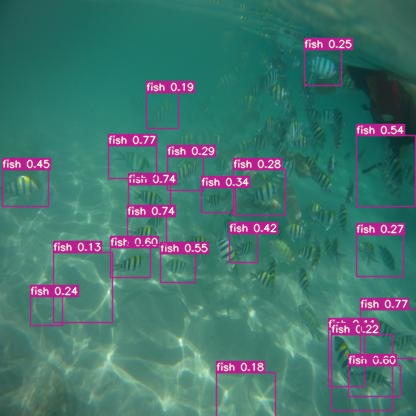


Instancia de animal marino a esquivar número 1



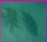


Instancia de animal marino a esquivar número 2




Instancia de animal marino a esquivar número 3




Instancia de animal marino a esquivar número 4



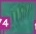


Instancia de animal marino a esquivar número 5



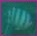


Instancia de animal marino a esquivar número 6



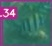


Instancia de animal marino a esquivar número 7



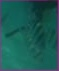


Instancia de animal marino a esquivar número 8



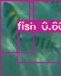


Instancia de animal marino a esquivar número 9



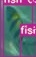


Instancia de animal marino a esquivar número 10




Instancia de animal marino a esquivar número 11



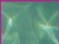


Instancia de animal marino a esquivar número 12



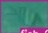


Instancia de animal marino a esquivar número 13




Instancia de animal marino a esquivar número 14




Instancia de animal marino a esquivar número 15




Instancia de animal marino a esquivar número 16



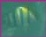


Instancia de animal marino a esquivar número 17




Instancia de animal marino a esquivar número 18



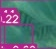


Instancia de animal marino a esquivar número 19




Instancia de animal marino a esquivar número 20



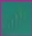


Instancia de animal marino a esquivar número 21



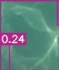



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.4927f140d2cd8c636bbce56225daede3.jpg



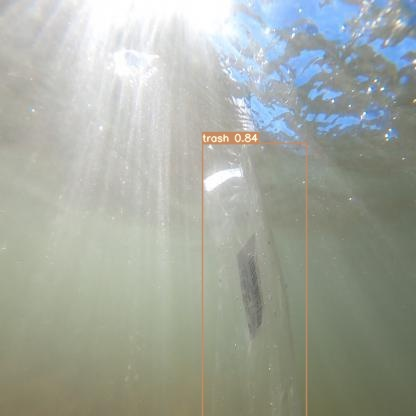


Instancia de basura a capturar número 1



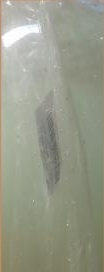



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00275_png_jpg.rf.640c33d3c960e6dbc7ce0990dfce8bfd.jpg



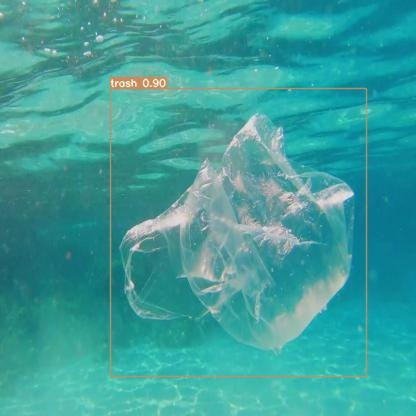


Instancia de basura a capturar número 1



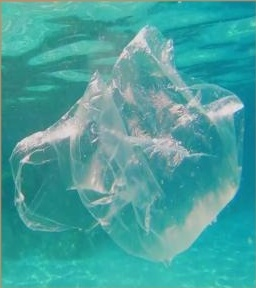



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/27_img__png_jpg.rf.e7c04c016dc9395944b0833d06d9886d.jpg



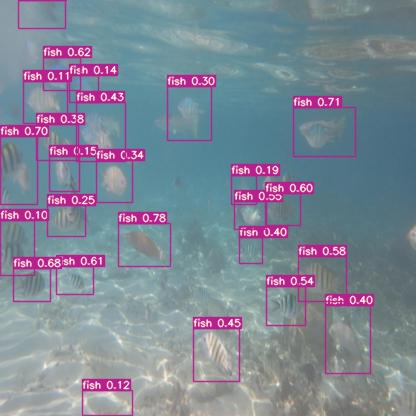


Instancia de animal marino a esquivar número 1



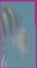


Instancia de animal marino a esquivar número 2



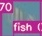


Instancia de animal marino a esquivar número 3




Instancia de animal marino a esquivar número 4



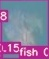


Instancia de animal marino a esquivar número 5



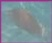


Instancia de animal marino a esquivar número 6




Instancia de animal marino a esquivar número 7



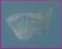


Instancia de animal marino a esquivar número 8




Instancia de animal marino a esquivar número 9



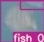


Instancia de animal marino a esquivar número 10



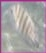


Instancia de animal marino a esquivar número 11



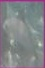


Instancia de animal marino a esquivar número 12



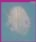


Instancia de animal marino a esquivar número 13



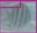


Instancia de animal marino a esquivar número 14




Instancia de animal marino a esquivar número 15



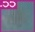


Instancia de animal marino a esquivar número 16




Instancia de animal marino a esquivar número 17



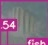


Instancia de animal marino a esquivar número 18




Instancia de animal marino a esquivar número 19



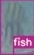


Instancia de animal marino a esquivar número 20



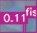


Instancia de animal marino a esquivar número 21




Instancia de animal marino a esquivar número 22




Instancia de animal marino a esquivar número 23



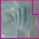


Instancia de animal marino a esquivar número 24



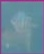


Instancia de animal marino a esquivar número 25





- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/351_img__png_jpg.rf.e90053eb376f320a4a52d170b3c45b8c.jpg



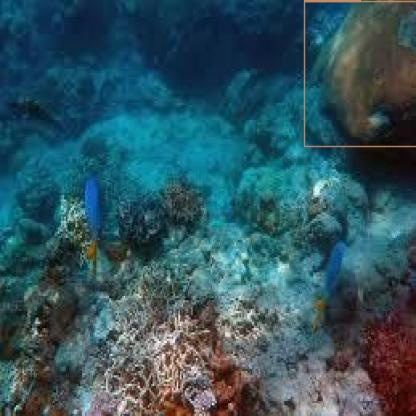


Instancia de basura a capturar número 1



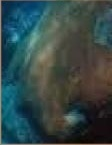



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00275_png_jpg.rf.8fb58c47829f0bebdbb789a03b80a02b.jpg



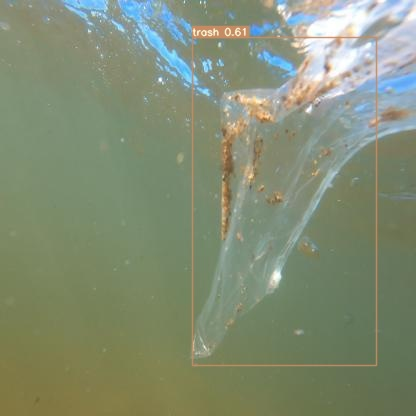


Instancia de basura a capturar número 1



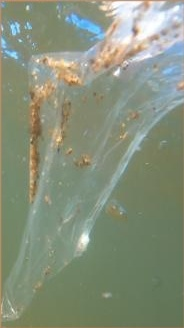



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.ec1ed2058a16fd294bc1c6517b944f12.jpg



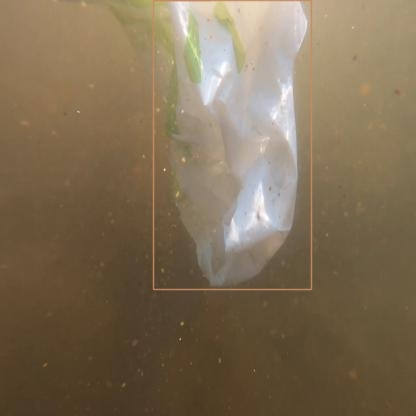


Instancia de basura a capturar número 1



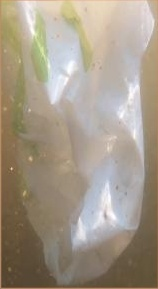



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00200_png_jpg.rf.26b26a25f398dccf73ae1acc0f9c66dd.jpg



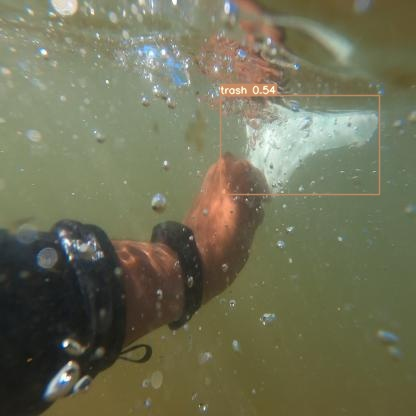


Instancia de basura a capturar número 1



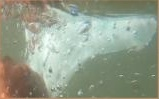



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00200_png_jpg.rf.79896f04acb8a7133f13cf02c3e577af.jpg



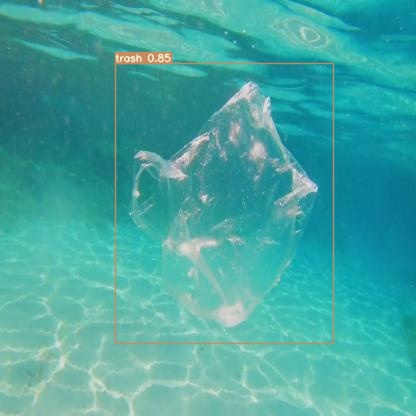


Instancia de basura a capturar número 1



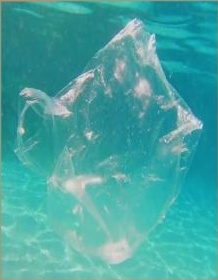



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00250_png_jpg.rf.614f4ca2b618cacdc4bd5baa72ee7bfe.jpg



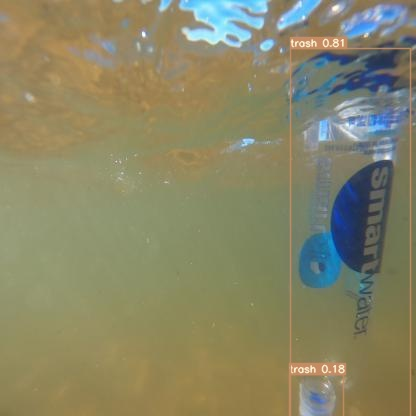


Instancia de basura a capturar número 1



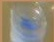


Instancia de basura a capturar número 2



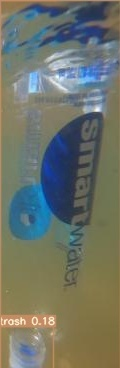



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.f9e3a45d386bbba92b76f766d3a2c38d.jpg



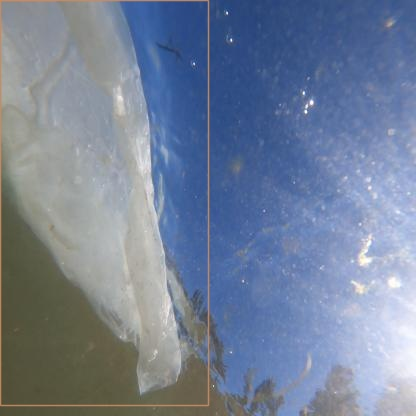


Instancia de basura a capturar número 1



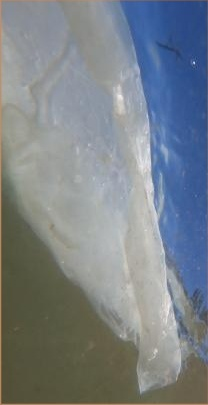



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00275_png_jpg.rf.223fce3c6e03d9140bce99397b5d3b3a.jpg



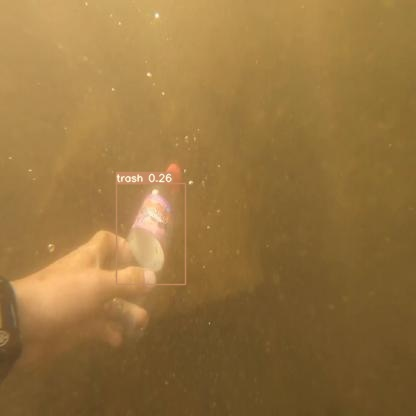


Instancia de basura a capturar número 1



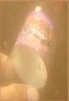



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.b6c2160338c368de9ea19e9a72070d7a.jpg



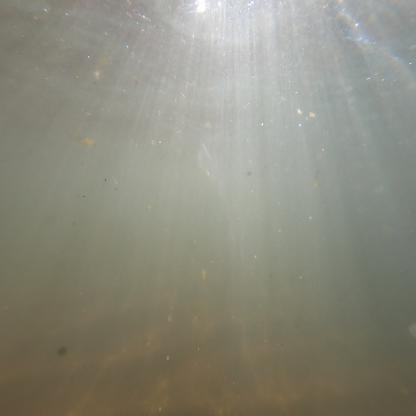



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00250_png_jpg.rf.3f36b80b4b07c7e56387f055aad0052a.jpg



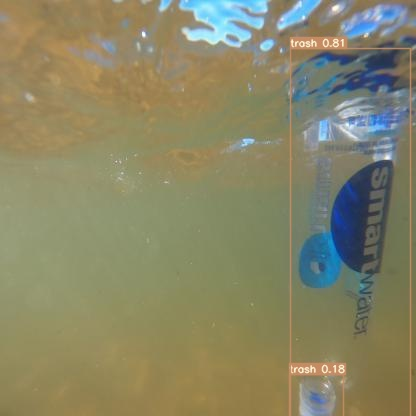


Instancia de basura a capturar número 1



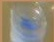


Instancia de basura a capturar número 2



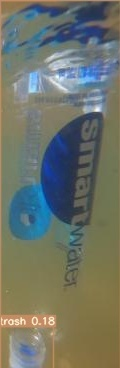



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00275_png_jpg.rf.38559fe695de9afe709553f2408db34c.jpg



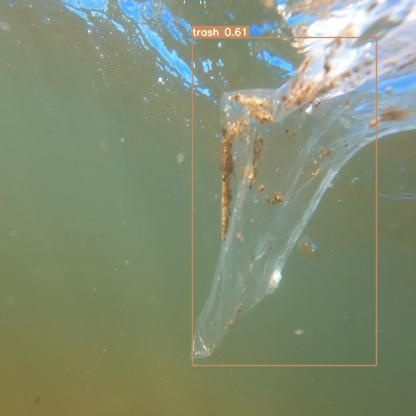


Instancia de basura a capturar número 1



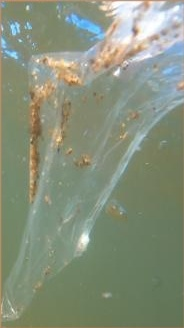



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/328_img__png_jpg.rf.7e90547e8cf4ebdbd4ae4b4da2404e65.jpg



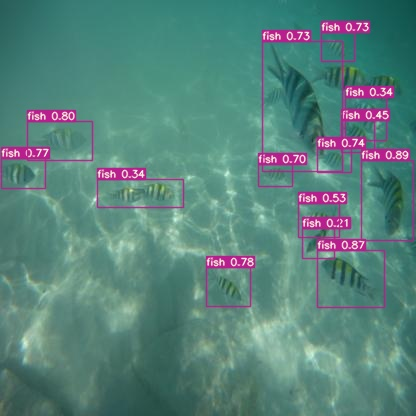


Instancia de animal marino a esquivar número 1



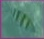


Instancia de animal marino a esquivar número 2



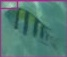


Instancia de animal marino a esquivar número 3




Instancia de animal marino a esquivar número 4




Instancia de animal marino a esquivar número 5




Instancia de animal marino a esquivar número 6




Instancia de animal marino a esquivar número 7



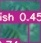


Instancia de animal marino a esquivar número 8




Instancia de animal marino a esquivar número 9




Instancia de animal marino a esquivar número 10



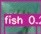


Instancia de animal marino a esquivar número 11



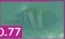


Instancia de animal marino a esquivar número 12



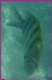


Instancia de animal marino a esquivar número 13



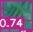


Instancia de animal marino a esquivar número 14



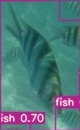



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00255_png_jpg.rf.c102be7e4ca0ece73fd82470b1d1847c.jpg



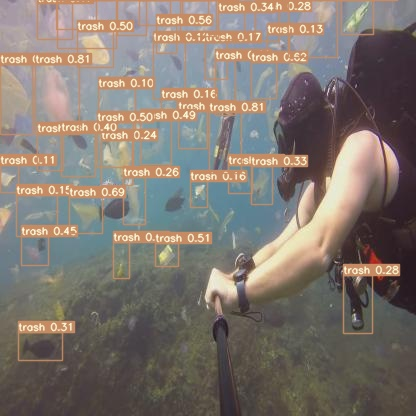


Instancia de basura a capturar número 1




Instancia de basura a capturar número 2



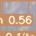


Instancia de basura a capturar número 3



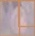


Instancia de basura a capturar número 4




Instancia de basura a capturar número 5




Instancia de basura a capturar número 6




Instancia de basura a capturar número 7




Instancia de basura a capturar número 8




Instancia de basura a capturar número 9




Instancia de basura a capturar número 10



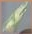


Instancia de basura a capturar número 11




Instancia de basura a capturar número 12




Instancia de basura a capturar número 13




Instancia de basura a capturar número 14



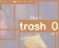


Instancia de basura a capturar número 15




Instancia de basura a capturar número 16




Instancia de basura a capturar número 17




Instancia de basura a capturar número 18



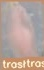


Instancia de basura a capturar número 19



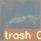


Instancia de basura a capturar número 20



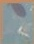


Instancia de basura a capturar número 21




Instancia de basura a capturar número 22




Instancia de basura a capturar número 23




Instancia de basura a capturar número 24



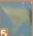


Instancia de basura a capturar número 25



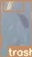


Instancia de basura a capturar número 26



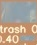


Instancia de basura a capturar número 27




Instancia de basura a capturar número 28



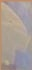


Instancia de basura a capturar número 29




Instancia de basura a capturar número 30




Instancia de basura a capturar número 31




Instancia de basura a capturar número 32



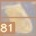


Instancia de basura a capturar número 33



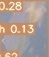


Instancia de basura a capturar número 34



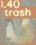


Instancia de basura a capturar número 35




Instancia de basura a capturar número 36




Instancia de basura a capturar número 37




Instancia de basura a capturar número 38




Instancia de basura a capturar número 39



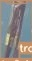


Instancia de basura a capturar número 40




Instancia de basura a capturar número 41





- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00250_png_jpg.rf.3652a443fc9e44cb60fea375a5c4b0df.jpg



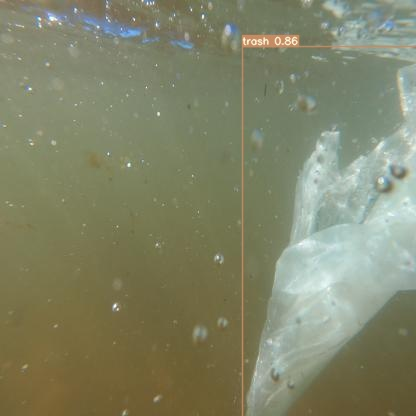


Instancia de basura a capturar número 1



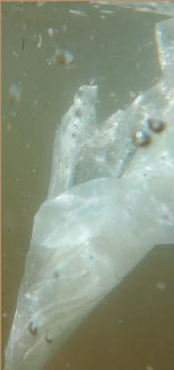



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00275_png_jpg.rf.3e2a533aacb814389c6584fc16695c68.jpg



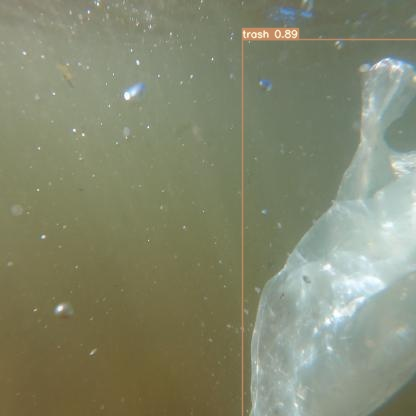


Instancia de basura a capturar número 1



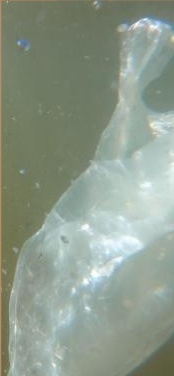



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00200_png_jpg.rf.2bbaf2d2aa71ab62c08253b58604c043.jpg



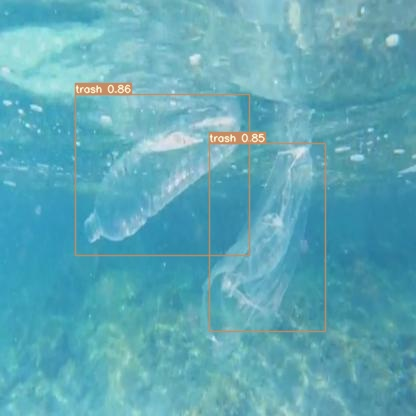


Instancia de basura a capturar número 1



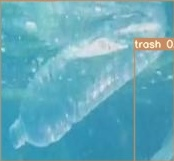


Instancia de basura a capturar número 2



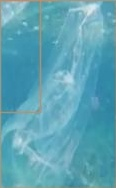



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00275_png_jpg.rf.251337a9aa0c41bd61f06e23c7f338ef.jpg



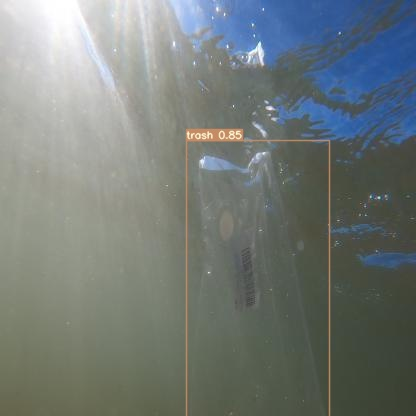


Instancia de basura a capturar número 1



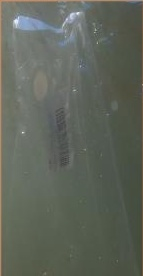



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/437_img__png_jpg.rf.c9b0f975467a367ec8c79224103594c0.jpg



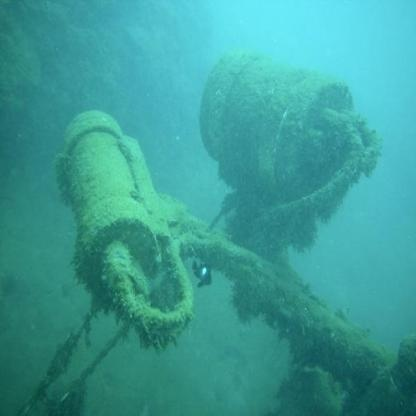



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.bb2603dda4a13de7b5a8a3f39e9bb2a0.jpg



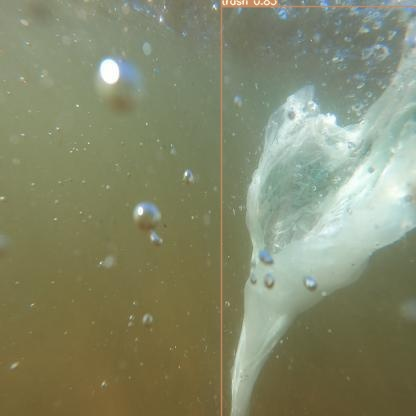


Instancia de basura a capturar número 1



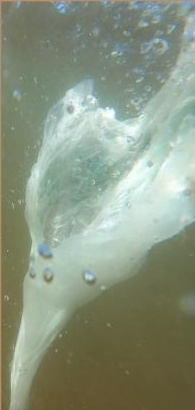



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00225_png_jpg.rf.cfacc786c35d654ec215a6202fd9f39f.jpg



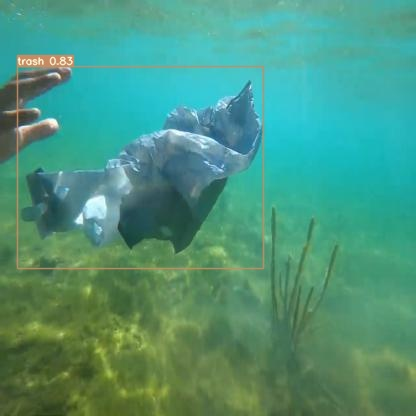


Instancia de basura a capturar número 1



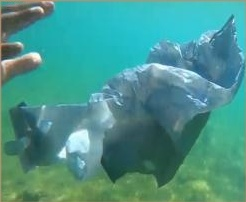



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/25_img__png_jpg.rf.9d52c5d818fb7773875ffe9c1b6449a9.jpg



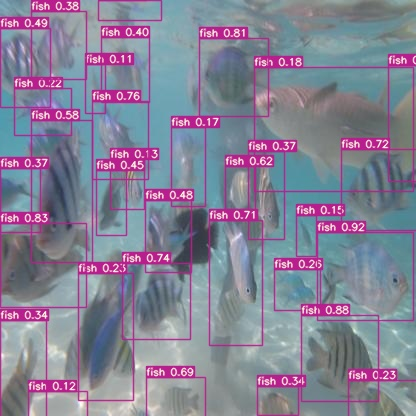


Instancia de animal marino a esquivar número 1




Instancia de animal marino a esquivar número 2



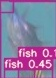


Instancia de animal marino a esquivar número 3




Instancia de animal marino a esquivar número 4



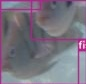


Instancia de animal marino a esquivar número 5



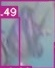


Instancia de animal marino a esquivar número 6



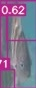


Instancia de animal marino a esquivar número 7



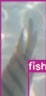


Instancia de animal marino a esquivar número 8



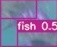


Instancia de animal marino a esquivar número 9



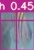


Instancia de animal marino a esquivar número 10



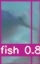


Instancia de animal marino a esquivar número 11



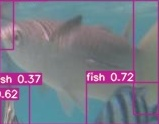


Instancia de animal marino a esquivar número 12




Instancia de animal marino a esquivar número 13



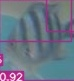


Instancia de animal marino a esquivar número 14



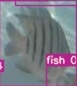


Instancia de animal marino a esquivar número 15



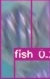


Instancia de animal marino a esquivar número 16



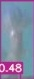


Instancia de animal marino a esquivar número 17



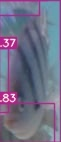


Instancia de animal marino a esquivar número 18



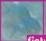


Instancia de animal marino a esquivar número 19




Instancia de animal marino a esquivar número 20




Instancia de animal marino a esquivar número 21



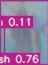


Instancia de animal marino a esquivar número 22



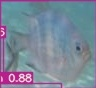


Instancia de animal marino a esquivar número 23



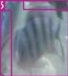


Instancia de animal marino a esquivar número 24



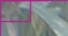


Instancia de animal marino a esquivar número 25



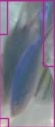


Instancia de animal marino a esquivar número 26




Instancia de animal marino a esquivar número 27




Instancia de animal marino a esquivar número 28



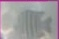


Instancia de animal marino a esquivar número 29




Instancia de animal marino a esquivar número 30



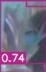


Instancia de animal marino a esquivar número 31



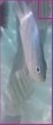


Instancia de animal marino a esquivar número 32



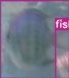



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Nombre del siguiente archivo: /content/myResults/frame_00300_png_jpg.rf.193c501c765f4da4105d0866af50e3a7.jpg



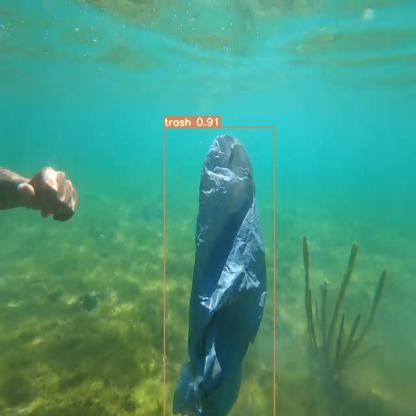


Instancia de basura a capturar número 1



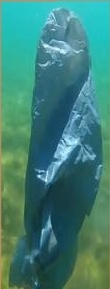



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


In [ ]:
#Veamos los resultados
import glob
from IPython.display import Image, display

i = 0
limit = 100 # max images to print
for imageName in glob.glob('/content/myResults/*.jpg'): #Aquí asumimos que los ficheros son JPG y que solo hemos hecho una detección, si hemos hecho más: cambiar exp por exp2,exp3 o la última
    if i < limit:
      
      print("Nombre del siguiente archivo: " + imageName)
      print()

      display(Image(filename=imageName))
      name = os.path.splitext(os.path.basename(imageName))[0] + "_inst_"
      name = os.path.basename(name)

      n_inst = 1
      for subImageName in glob.glob('/content/Catch/' + name + "*.jpg"):
        print()
        print("Instancia de basura a capturar número " + str(n_inst))
        print()
        display(Image(filename=subImageName))
        n_inst += 1
      
      n_inst = 1
      for subImageName in glob.glob('/content/Dodge/' + name + "*.jpg"):
        print()
        print("Instancia de animal marino a esquivar número " + str(n_inst))
        print()
        display(Image(filename=subImageName))
        n_inst += 1
      
      print()
      print()
      print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

    i = i + 1
    